In [ ]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import tensorflow as tf
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import rasterio
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import math
import pdb
from keras.callbacks import CSVLogger
import shap

print("tf version", tf. __version__)

In [ ]:
# Needed for SHAP
# tf.compat.v1.disable_v2_behavior()

In [2]:
# Set the working directory
os.getcwd()
os.chdir('/home/shoyo/Desktop')

In [3]:
# Set seed
seed = 42
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  # tf.experimental.numpy.random.seed(seed)
  # tf.compat.v1.get_seed(seed)
  # tf.compat.v1.set_random_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  os.environ['CUDA_VISIBLE_DEVICES'] = " "
set_seed(42)

tf.config.experimental.enable_op_determinism()

In [4]:
# Remove extreme data and load the csv file
csv_path = os.getcwd() + '/SOC6m3119.csv'
df1 = pd.read_csv(csv_path)
df2 = df1[ (df1.EVI<-1) | (df1.EVI>1) ]

df = pd.DataFrame(columns=df1.columns)
for i in range(len(df1)):
    lat = df1.loc[i, 'latitude']
    lon = df1.loc[i, 'longitude']
    if not ((df2['latitude'] == lat) & (df2['longitude'] == lon)).any():
        # df = pd.concat([df, df1.loc[i]]) 
        df.loc[len(df)] = df1.iloc[i]
        # df = df.append(df1.loc[i]) 

df['temp'] = df['temp']*0.02
df = df.drop(columns=['latitude', 'longitude', 'year', 'LC', 'site', 'siteid'])
df

,SOC,elev,slope,aspect,roughness,twi,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,EVI,VV,VH,VV/VH,prec,temp
0,18.08215,733,14.546583,6.157959,33.428909,-2.764669,0.495186,0.50455,0.508799,0.619528,0.421844,0.302109,0.249578,0.076579,0.020804,3.680936,18.45042,299.087895
1,18.08215,733,14.546583,6.157959,33.428909,-2.764669,0.613395,0.590047,0.607551,0.644841,0.527856,0.41699,0.130808,0.055299,0.009868,5.604137,12.463107,303.8782
2,18.08215,733,14.546583,6.157959,33.428909,-2.764669,0.514794,0.547574,0.553665,0.657051,0.36925,0.229632,0.677022,0.086492,0.016536,5.230641,15.063257,299.177303
3,18.08215,733,14.546583,6.157959,33.428909,-2.764669,0.540919,0.547203,0.565229,0.665329,0.528585,0.450788,0.214224,0.097643,0.016181,6.034561,15.205925,302.826742
4,8.9793,1071,19.300432,22.724434,49.945877,-2.874085,0.016301,0.061058,0.062419,0.216707,0.145029,0.096973,0.240661,0.183756,0.058889,3.120377,15.831832,305.77443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12435,8.04395,202,2.780292,98.300659,1.328088,0.017878,0.314814,0.350633,0.369993,0.53733,0.409056,0.296911,0.302399,0.235468,0.073275,3.213477,10.421789,303.051429
12436,7.548,1064,2.074803,253.801025,1.301188,0.200059,0.042935,0.09051,0.129367,0.229412,0.177712,0.159315,0.116971,0.017431,0.002679,6.505904,5.778829,315.733571
12437,7.548,1064,2.074803,253.801025,1.301188,0.200059,0.24198,0.281662,0.31645,0.372358,0.359886,0.312889,0.054294,0.016506,0.002907,5.678041,3.777829,314.70129
12438,7.548,1064,2.074803,253.801025,1.301188,0.200059,0.162642,0.204951,0.247645,0.303113,0.313219,0.267266,0.067999,0.01521,0.003347,4.544754,0.03365,311.041622


In [5]:
# Randomly shuffle the dataset

array = list(range(3111))
# random.shuffle(array)
np.random.seed(42)
np.random.shuffle(array)

# Create a new column to group rows into blocks of 5
df['Group'] = (df.index // 4) + 1

dataframe = pd.DataFrame(columns=df.columns)
for idx in array:
    dataframe = pd.concat([dataframe, df[df['Group']==idx]])
df = dataframe.drop('Group', axis=1)
df

,SOC,elev,slope,aspect,roughness,twi,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,EVI,VV,VH,VV/VH,prec,temp
2768,3.001,903,0.0,74.296715,3.89493,-0.646753,0.273027,0.324081,0.332221,0.467961,0.370735,0.270841,0.240392,0.127944,0.04597,2.783185,14.176126,310.321489
2769,3.001,903,0.0,74.296715,3.89493,-0.646753,0.063257,0.110722,0.145689,0.255111,0.306165,0.234706,0.165311,0.122056,0.044567,2.738721,5.722329,313.08549
2770,3.001,903,0.0,74.296715,3.89493,-0.646753,0.225755,0.257944,0.288785,0.397616,0.361935,0.297007,0.141066,0.127785,0.042382,3.015099,5.939683,313.592233
2771,3.001,903,0.0,74.296715,3.89493,-0.646753,0.429503,0.44559,0.48596,0.534882,0.498528,0.334435,0.101622,0.117461,0.044535,2.637493,6.445731,313.613182
6952,56.0463,6,0.930886,70.33654,0.925001,1.136538,0.321097,0.358965,0.365262,0.446992,0.331877,0.232025,0.11371,0.11494,0.028035,4.099873,22.897598,302.169444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5175,9.1428,1125,2.074021,106.706802,1.412552,-0.059693,0.345779,0.368315,0.386767,0.449385,0.386314,0.296636,0.161647,0.057623,0.006526,8.829626,9.597857,310.549107
3436,2.57125,936,2.621616,37.136879,7.058666,2.519029,0.179486,0.20634,0.21261,0.314621,0.239533,0.16773,0.210077,0.120956,0.037395,3.234552,15.831832,307.855952
3437,2.57125,936,2.621616,37.136879,7.058666,2.519029,0.05905,0.118656,0.15838,0.318581,0.328701,0.23769,0.190573,0.098309,0.030884,3.1832,5.908134,310.692816
3438,2.57125,936,2.621616,37.136879,7.058666,2.519029,0.327409,0.362389,0.401851,0.487651,0.442469,0.34901,0.144435,0.105682,0.038585,2.738966,7.409822,311.541633


In [7]:
# Scale the data
scaler = MinMaxScaler()
n = len(df)

# train_df = scaler.fit_transform(df[0:int(n*0.8)])
# val_df = scaler.transform(df[int(n*0.8):int(n*0.9)])
# test_df = scaler.transform(df[int(n*0.9):])
train_df = scaler.fit_transform(df[:9952])
val_df = scaler.transform(df[9952:(9952+1244)])
test_df = scaler.transform(df[(9952+1244):])
max = np.max(df[:9952].SOC)
min = np.min(df[:9952].SOC)

Xtrain = train_df[:,1:]
Ytrain = train_df[:,0]
# [::5]

Xval = val_df[:,1:]
Yval = val_df[:,0]
# [::5]

Xtest = test_df[:,1:]
Ytest = test_df[:,0]
# [::5]

# Reshape it to be (n_data, time_step, feature)
Xtrain = np.reshape(Xtrain, (int(Xtrain.shape[0]/4), 4, Xtrain.shape[1]))
Xval = np.reshape(Xval, (int(Xval.shape[0]/4), 4, Xval.shape[1]))
Xtest = np.reshape(Xtest, (int(Xtest.shape[0]/4), 4, Xtest.shape[1]))

# Reshape it to be (n_data, time_step)
Ytrain = np.reshape(Ytrain, (int(Ytrain.shape[0]/4), 4))
Yval = np.reshape(Yval, (int(Yval.shape[0]/4), 4))
Ytest = np.reshape(Ytest, (int(Ytest.shape[0]/4), 4))

In [11]:
# Show metadsata of the dataset
df.apply(['mean', 'median', 'max', 'min', 'std', 'skew', 'count']).transpose()

,mean,median,max,min,std,skew,count
SOC,10.833625,8.066600,119.511800,1.612800,10.502853,3.933429,12440.0
elev,834.919936,945.500000,2022.000000,-3.000000,499.922663,-0.222540,12440.0
slope,5.135545,2.930427,44.899754,0.000000,6.796189,2.764508,12440.0
aspect,167.911017,159.812782,359.977112,0.032219,106.974139,0.190601,12440.0
roughness,15.927020,5.875148,201.859283,0.215358,26.914511,2.875569,12440.0
twi,0.367423,0.057538,10.531526,-3.988649,2.111902,1.142238,12440.0
SR_B2,0.236737,0.171264,1.196863,-0.091829,0.205376,1.224088,12440.0
SR_B3,0.276594,0.223424,1.146070,-0.024014,0.179884,1.211824,12440.0
SR_B4,0.292090,0.245136,1.162487,-0.021992,0.179948,1.090975,12440.0
SR_B5,0.420113,0.400751,1.152450,0.038590,0.142728,0.850422,12440.0


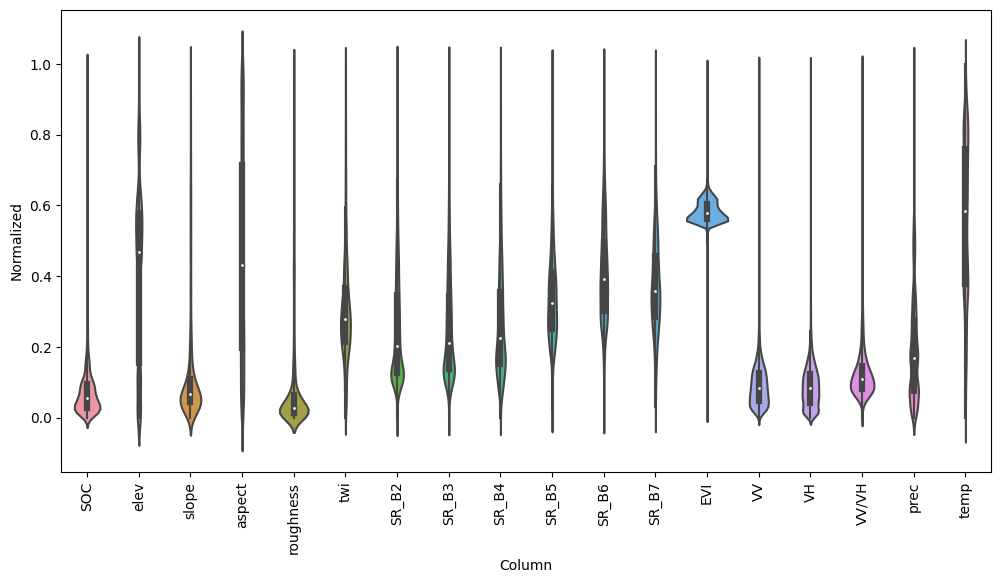

In [12]:
g# Show the value ranges of the dataset
df_std = pd.DataFrame(train_df).melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [45]:
# Compute R-squared metric
def r_squared(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2_score = 1.0 - tf.divide(residual, total)
    return r2_score

In [ ]:
# Hyperparameter tuning using the validation dataset
# initializer = tf.keras.initializers.GlorotUniform(seed=42)
batch_size = [64, 128, 256]
units = [32, 64, 128, 256]
units_dense = 1
lr = [0.5, 0.1, 0.05, 0.01, 0.005]
epochs = 200
do = [0, 0.1, 0.2, 0.3]
info = pd.DataFrame(columns=['batchsize', 'unit', 'learningrate', 'dropout', 'optimizer', 'model', 'rmse', 'r2'])
i = 0

for batchSize in batch_size:
    for unit in units:
        for learnRate in lr:
            learningRate = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=learnRate, decay_steps=10000, decay_rate=0.96)
            for dropout in do:

                model1 = tf.keras.models.Sequential([
                    tf.keras.layers.LSTM(unit, input_shape=(None, Xtrain.shape[2])),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Dropout(dropout, seed=seed),
                    tf.keras.layers.Dense(units_dense, activation='linear')])
                
                model2 = tf.keras.models.Sequential([
                    tf.keras.layers.LSTM(unit, input_shape=(None, Xtrain.shape[2]), return_sequences=True),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Dropout(dropout, seed=seed),
                    tf.keras.layers.LSTM(int(unit/2), return_sequences=False),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Dropout(dropout, seed=seed),
                    tf.keras.layers.Dense(units_dense, activation='linear')])

                model3 = tf.keras.models.Sequential([
                    tf.keras.layers.LSTM(unit, input_shape=(None, Xtrain.shape[2]), return_sequences=True),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Dropout(dropout, seed=seed),
                    tf.keras.layers.LSTM(int(unit/2), return_sequences=True),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Dropout(dropout, seed=seed),
                    tf.keras.layers.LSTM(int(unit/4), return_sequences=False),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Dropout(dropout, seed=seed),
                    tf.keras.layers.Dense(units_dense, activation='linear')
                ])

                model4 = tf.keras.models.Sequential([
                    tf.keras.layers.LSTM(unit, input_shape=(None, Xtrain.shape[2]), return_sequences=True),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Dropout(dropout, seed=seed),
                    tf.keras.layers.LSTM(int(unit/2), return_sequences=True),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Dropout(dropout, seed=seed),
                    tf.keras.layers.LSTM(int(unit/4), return_sequences=True),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Dropout(dropout, seed=seed),
                    tf.keras.layers.LSTM(int(unit/8), return_sequences=False),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Dropout(dropout, seed=seed),
                    tf.keras.layers.Dense(units_dense, activation='linear')
                ])
                
                for j in range(4):
                    model = [model1, model2, model3, model4][j]

                    for optimizer in [tf.keras.optimizers.Adam(learning_rate=learningRate)]:
                        # , tf.keras.optimizers.SGD(learning_rate=learningRate)
                        print(i)

                        model.compile(loss=tf.keras.losses.MeanSquaredError(),
                            optimizer=optimizer,
                            metrics=[tf.keras.metrics.MeanAbsoluteError(), 
                                    tf.keras.metrics.RootMeanSquaredError(),
                                    r_squared
                                    ])

                        # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='LSTM', update_freq='epoch', profile_batch=0)
                        early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss')

                        history = model.fit(Xtrain, Ytrain, 
                                            epochs=epochs, 
                                            batch_size=batchSize,
                                            validation_data=(Xval, Yval), 
                                            callbacks=[early_stopping]
                                            )
                        
                        Ypred = model.predict(Xval)
                        Yvalidation = np.array([sublist[::4] for sublist in Yval])
                        # Ypred = Ypred * (max-min) + min
                        # Yvalupdate = Yval * (max-min) + min

                        mse = mean_squared_error(Yvalidation, Ypred)
                        print("RMSE", math.sqrt(mse))
                        mae = mean_absolute_error(Yvalidation, Ypred)
                        print("MAE", mae)
                        R_square = r2_score(Yvalidation, Ypred) 
                        print('Coefficient of Determination', R_square) 

                        addCol = pd.Series( [ batchSize, unit, learnRate, dropout, optimizer, str(j+1), math.sqrt(mse), R_square ],
                            index=info.columns 
                            )
                        
                        info.loc[i] = addCol

                        i=i+1

print(info)
info.to_csv(os.getcwd() + '/info2y.csv', index=False)

In [ ]:
# Check the hyperparameter settings that gave better R-squared results
info[info.r2>0.815]

,batchsize,unit,learningrate,dropout,optimizer,model,rmse,r2
151,64,64,0.005,0.1,<keras.optimizers.adam.Adam object at 0x7f851c...,4,0.038413,0.829043
458,128,64,0.01,0.2,<keras.optimizers.adam.Adam object at 0x7f8564...,3,0.039455,0.819637
551,128,128,0.005,0.1,<keras.optimizers.adam.Adam object at 0x7f85fc...,4,0.039855,0.815963
934,256,256,0.01,0.1,<keras.optimizers.adam.Adam object at 0x7f84b2...,3,0.039269,0.821341


In [47]:
# Define the potential best model and its hyperparameters
batch_size = 128
unit = 64
units_dense = 1
lr = 0.01
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=10000,
    decay_rate=0.96)
epochs = 1200
dropout = 0.2
model = model3

In [48]:
# See the model details
print('train data size', len(train_df)/4)
model.summary()

train data size 2488.0
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, None, 32)          6400      
                                                                 
 batch_normalization_19 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 dropout_19 (Dropout)        (None, None, 32)          0         
                                                                 
 lstm_20 (LSTM)              (None, None, 16)          3136      
                                                                 
 batch_normalization_20 (Bat  (None, None, 16)         64        
 chNormalization)                                                
                                                                 
 dropout_20 (Dropout)        (N

In [ ]:
# Train the model
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=[tf.keras.metrics.MeanAbsoluteError(), 
                       tf.keras.metrics.RootMeanSquaredError(),
                    #    r_squared
                       ])

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='LSTM', update_freq='epoch', profile_batch=0)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss')

history = model.fit(Xtrain, Ytrain, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=(Xval, Yval), 
                    callbacks=[early_stopping]
                    )

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('MAE')
plt.ylabel('Mean absolute error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MSE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
# Predict SOC using test dataset
Ypred = model.predict(Xtest)
y_test = np.array([sublist[::4] for sublist in Ytest])
Ypred = Ypred * (max-min) + min
YtestCorrect = y_test * (max-min) + min
print('shape', Ypred.shape)
print(Ypred[:10], np.max(Ypred), np.min(Ypred))

In [ ]:
# Calculate the metric values
mse = mean_squared_error(YtestCorrect, Ypred)
print("RMSE", math.sqrt(mse))
mae = mean_absolute_error(YtestCorrect, Ypred)
print("MAE", mae)
R_square = r2_score(YtestCorrect, Ypred) 
print('Coefficient of Determination', R_square) 

In [ ]:
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='LSTM', update_freq='epoch', profile_batch=0)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss')
csv_logger = CSVLogger('training.log2y.csv', separator=',', append=False)

history = model.fit(Xtrain, Ytrain, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=(Xval, Yval), 
                    callbacks=[early_stopping, csv_logger]
                    )

# Predict SOC using test dataset
Ypred = model.predict(Xtest)
y_test = np.array([sublist[::4] for sublist in Ytest])
Ypred = Ypred * (max-min) + min
YtestCorrect = y_test * (max-min) + min

# Calculate the metric values
mse = mean_squared_error(YtestCorrect, Ypred)
print("RMSE", math.sqrt(mse))
mae = mean_absolute_error(YtestCorrect, Ypred)
print("MAE", mae)
R_square = r2_score(YtestCorrect, Ypred) 
print('Coefficient of Determination', R_square) 

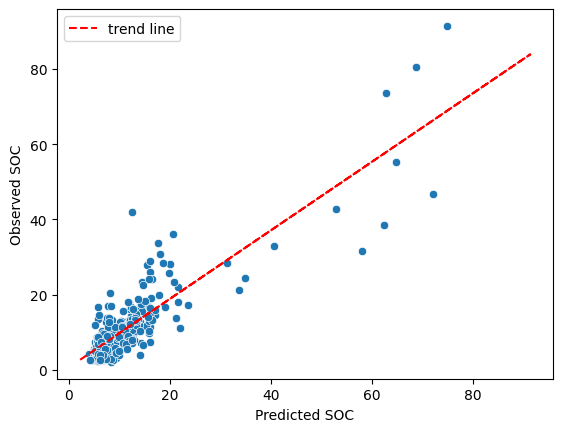

In [88]:
# Plot the predicted SOC against the observed SOC
scatterplot=sns.scatterplot(x=np.squeeze(Ypred), y=np.squeeze(YtestCorrect))
z = np.polyfit(np.squeeze(Ypred), np.squeeze(YtestCorrect), 1)  #Least squares polynomial fit.
p = np.poly1d(z)                           #A one-dimensional polynomial class.
scatterplot.plot(np.squeeze(YtestCorrect), p(np.squeeze(YtestCorrect)), "r--", label='trend line')
# plt.xlim([-0.1, 1.1])
# plt.ylim([-0.1, 1.1])
plt.legend()
plt.xlabel("Predicted SOC")
plt.ylabel("Observed SOC")
plt.show()

2023-07-27 10:22:31.791246: W tensorflow/c/c_api.cc:300] Operation '{name:'total_22/Assign' id:21890 op device:{requested: '', assigned: ''} def:{{{node total_22/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_22, total_22/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


<BarContainer object of 17 artists>

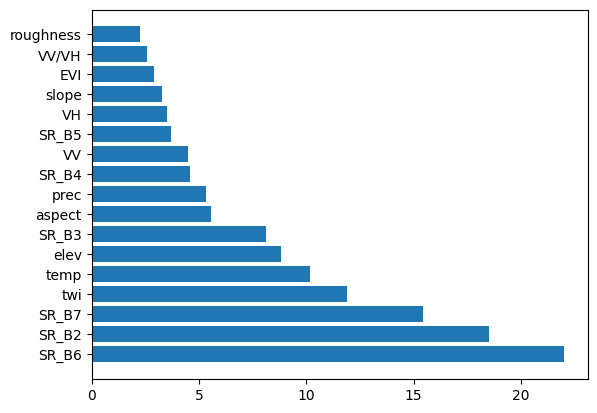

In [140]:
# SHapley Additive exPlanations
explainer = shap.DeepExplainer(model, Xtrain)
shap_values = explainer.shap_values(Xtest)

shap_abs = np.absolute(shap_values[0])

sum = np.sum(shap_abs, axis=0)

sum2 = np.mean(sum, axis=0)
sum2 = sum2 * (max-min) + min

variables = ['elev', 'slope', 'aspect', 'roughness', 'twi', 'SR_B2', 'SR_B3',
       'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'EVI', 'VV', 'VH', 'VV/VH', 'prec',
       'temp']

sorted_data = sorted(zip(sum2, variables), reverse=True)
sorted_values, sorted_features = zip(*sorted_data)

plt.barh(sorted_features, sorted_values)

In [56]:
# SHapley Additive exPlanations
explainer = shap.DeepExplainer(model, Xtrain)
shap_values = explainer.shap_values(Xtest)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
2023-07-25 16:15:59.555220: W tensorflow/c/c_api.cc:300] Operation '{name:'count_11/Assign' id:12611 op device:{requested: '', assigned: ''} def:{{{node count_11/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_11, count_11/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [127]:
shap_abs = np.absolute(shap_values[0])

In [70]:
shap.initjs()

In [128]:
sum = np.sum(shap_abs, axis=0)

In [129]:
sum2 = np.mean(sum, axis=0)
sum2 = sum2 * (max-min) + min

In [130]:
sum2

array([ 8.82824243,  3.30265813,  5.5443806 ,  2.26353515, 11.90683351,
       18.52556514,  8.13220954,  4.57504136,  3.70300973, 22.00923044,
       15.42077463,  2.88874679,  4.47142355,  3.53619134,  2.5640125 ,
        5.3405393 , 10.18794128])

In [100]:
variables = ['elev', 'slope', 'aspect', 'roughness', 'twi', 'SR_B2', 'SR_B3',
       'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'EVI', 'VV', 'VH', 'VV/VH', 'prec',
       'temp']


<BarContainer object of 17 artists>

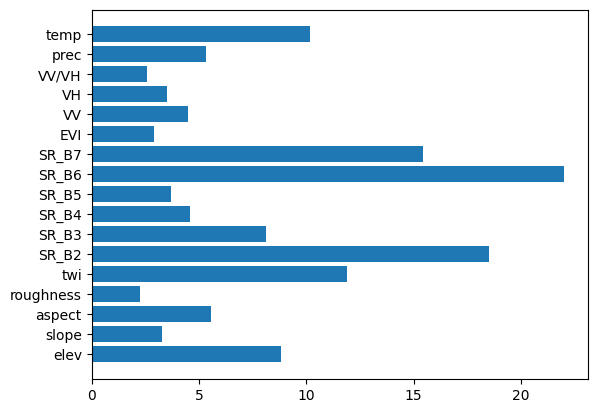

In [134]:
plt.barh(variables, sum2)

<BarContainer object of 17 artists>

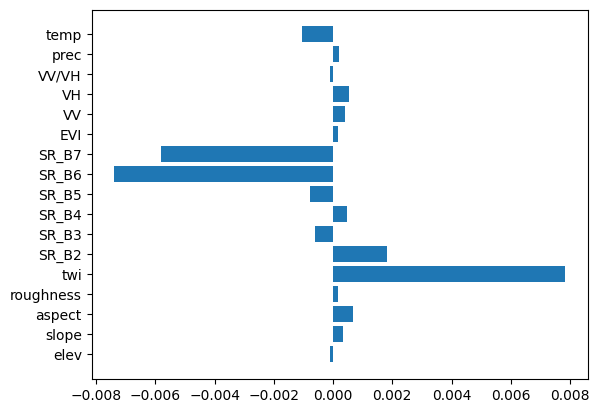

In [107]:
plt.barh(variables, sum[3])

<BarContainer object of 17 artists>

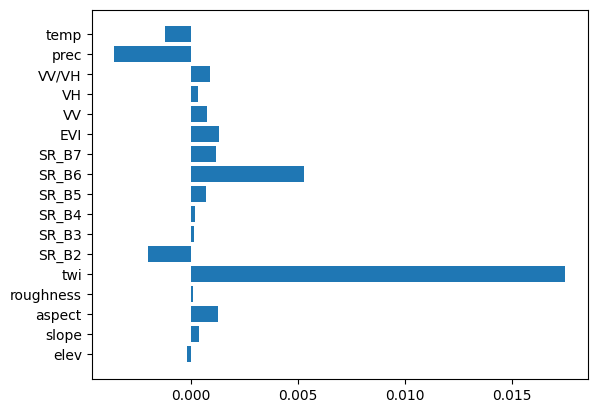

In [106]:
plt.barh(variables, sum[2])

<BarContainer object of 17 artists>

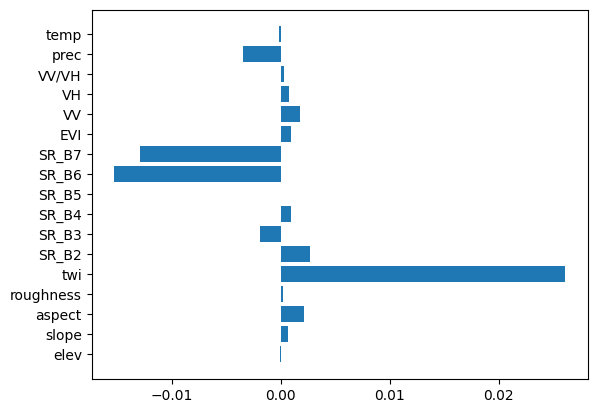

In [105]:
plt.barh(variables, sum[1])

<BarContainer object of 17 artists>

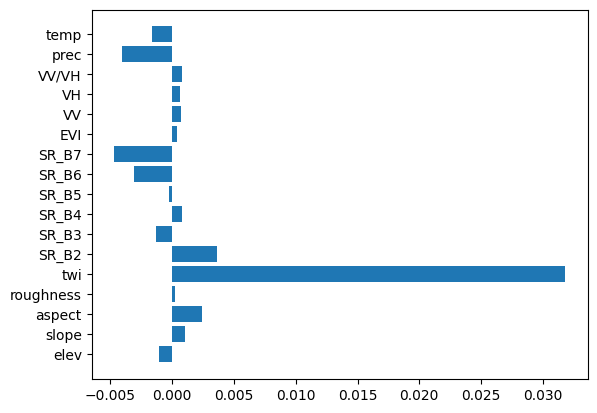

In [102]:
plt.barh(variables, sum[0])

In [ ]:
# Save the trained model
model.save(os.getcwd() + '/LSTM2y', save_format='tf')

In [ ]:
# Check if the model can be properly loaded
model = tf.keras.models.load_model(os.getcwd() + '/LSTM2y') 